In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and inspect dataset

df = pd.read_csv('diabetes.csv')
print("Dataset loaded successfully!")
print(df.head())
print("\nMissing values per column:\n", df.isnull().sum())

Dataset loaded successfully!
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outco

In [3]:
# Handle missing or zero values 
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_replace] = df[cols_to_replace].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

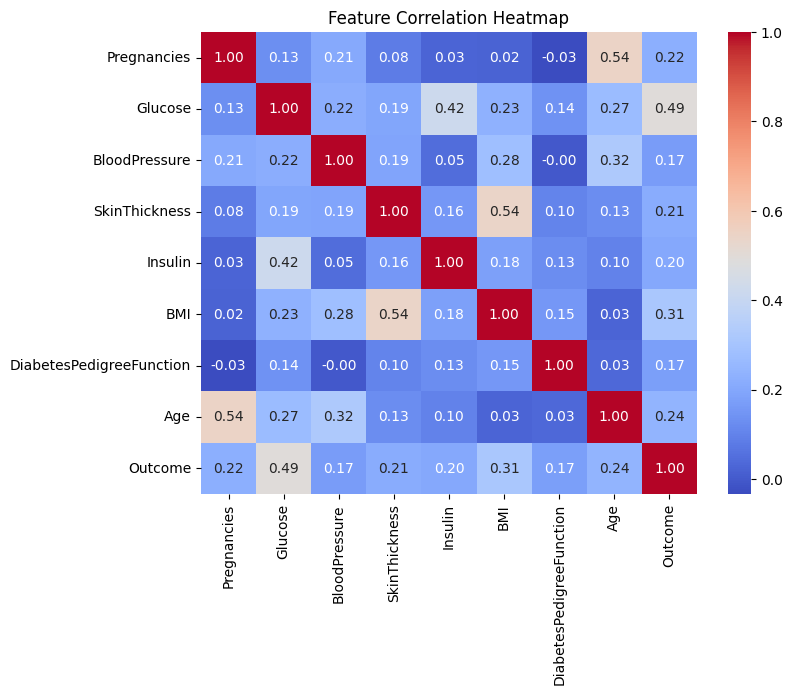

In [4]:
# Correlation heatmap 
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [5]:
# Split features and labels

X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [6]:
#  Scale features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Handle class imbalance with SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)
print(f"Before SMOTE: {y.value_counts().to_dict()}")
print(f"After SMOTE: {y_res.value_counts().to_dict()}")

Before SMOTE: {0: 500, 1: 268}
After SMOTE: {1: 500, 0: 500}


In [8]:
# Split into train/test sets

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [9]:
# Train models and tune hyperparameters

# Logistic Regression
lr_params = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, scoring='f1', cv=5)
lr_grid.fit(X_train, y_train)

# Random Forest
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10], 'class_weight': ['balanced']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, scoring='f1', cv=5)
rf_grid.fit(X_train, y_train)

# SVM
svm_params = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'class_weight': ['balanced']}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, scoring='f1', cv=5)
svm_grid.fit(X_train, y_train)

,estimator,SVC(probabili...ndom_state=42)
,param_grid,"{'C': [0.1, 1, ...], 'class_weight': ['balanced'], 'kernel': ['rbf', 'linear']}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


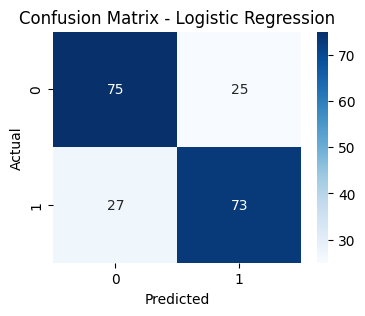


Logistic Regression Results:
[[75 25]
 [27 73]]
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       100
           1       0.74      0.73      0.74       100

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.74      0.74      0.74       200



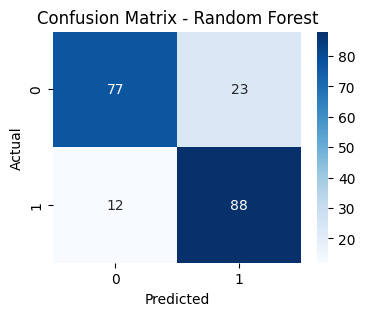


Random Forest Results:
[[77 23]
 [12 88]]
              precision    recall  f1-score   support

           0       0.87      0.77      0.81       100
           1       0.79      0.88      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



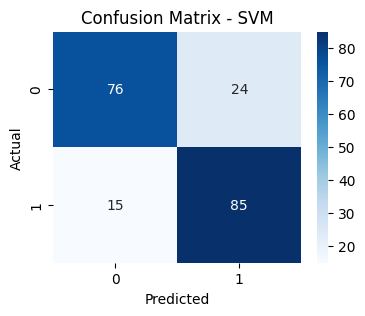


SVM Results:
[[76 24]
 [15 85]]
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       100
           1       0.78      0.85      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200



In [10]:
# Evaluate all models

models = {
    'Logistic Regression': lr_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_,
    'SVM': svm_grid.best_estimator_
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    }

    # Confusion matrix heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"\n{name} Results:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

<Figure size 800x500 with 0 Axes>

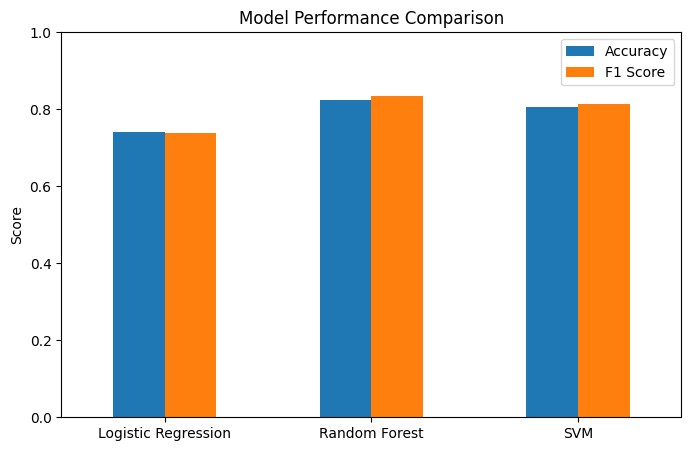

In [11]:
# Model Comparison Visualization

results_df = pd.DataFrame(results).T
plt.figure(figsize=(8,5))
results_df[['Accuracy', 'F1 Score']].plot(kind='bar', figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

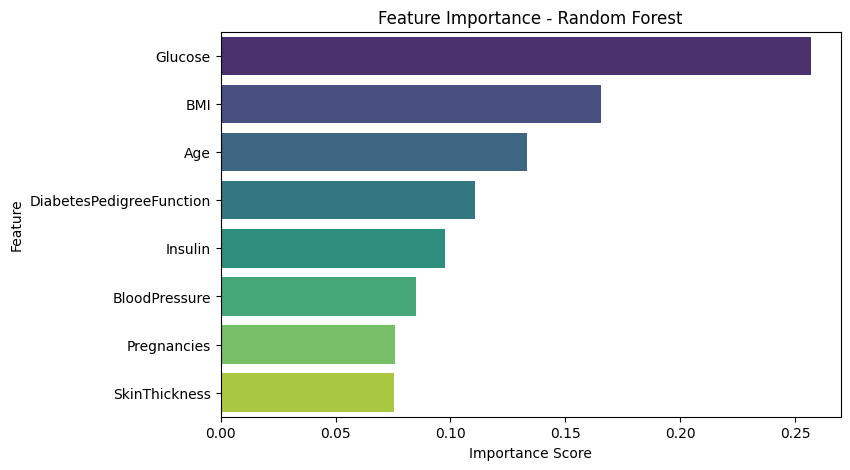

In [59]:
# Feature Importance (Random Forest)

importances = rf_grid.best_estimator_.feature_importances_
feat_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [15]:
# Select and save best model

best_model_name = max(results, key=lambda k: results[k]['Accuracy'])
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['Accuracy']:.4f}")

# Save model, scaler, and metadata
model_data = {
    'model': best_model,
    'scaler': scaler,
    'model_name': best_model_name
}

with open('diabetes_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("\n Model saved successfully as 'diabetes_model.pkl'")

Best Model: Random Forest
Accuracy: 0.8250

 Model saved successfully as 'diabetes_model.pkl'
